In [55]:
import numpy as np
import hapi  
from dur_utils import colours
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import cauchy
from scipy.integrate import simpson
import isa
mpl.style.use('../CDS.mplstyle')

## $\textrm{CO}_2$ at Ground-Level

The starting point for absorption spectra of greenhouse gasses in the atmosphere is to look at their absorption spectra at their reference temperature and pressure. Further, it is worth looking at the differences in widths of the cross-section components. The width comparisons enable determinataion of the dominant broadening effect. 

Additionally, to temperature dependence on the broadening, there is a further temperature dependence on the line intensity due to the accessibility of a given transition. At low temperature, high-energy transitions, those of low wavelength, are heavily surppressed as the molecules lack the energy to access either the excitation or vibrational mode. A Bose-Einstein distribution quantifies the availability of a transition. When the intensity of a transition is known for one temperature, the ratio of the probabilities gives the intensity
```{math}
:label:
S_{a \rightarrow b}(T) = S_{a \rightarrow b, T_ref}\frac{\exp(-h\nu_{a \rightarrow b} /cK_bT)}{exp(-h\nu_{a \rightarrow b} /cK_b T_{ref})} \frac{Q(T_{ref})}{Q(T)}
```
Where $S_{a \rightarrow b}(T)$ is the line intensity as a function of temperature for some transition $a \rightarrow b$, $\nu_{a \rightarrow b}$ is the wavenumber for the transition, and $Q(T) is the partition sum over all states. The values for $S_{a \rightarrow b}(T_{ref})$ are recorded on the hitran data-base.

In [2]:
hapi.db_begin('../hapi_db')


Using ../hapi_db

CH4
                     Lines parsed: 139468
NH3
                     Lines parsed: 44086
N2
                     Lines parsed: 453
N2O
                     Lines parsed: 27201
O2
                     Lines parsed: 737
CO2
                     Lines parsed: 103240
H2O
                     Lines parsed: 38350


##  Standard Atmosphere Model
The "US Standard Atmosphere, 1976"{cite}`USAtmosphere` provides pressure, temperature, and density vertical profiles. The model takes values which are roughly representative of year-round mid-latitude conditions. An approximate atmospheric profile is important to calculate molecule concentrations and cross-section broadening. A resonable assumption in the troposphere is that the relative fractions stay the same. Thus the decrease in atmospheric density provides the main trail off for total absorption. The constant relative fraction of greenhouse gases breaks down, particularly for water and ozone above the 10km mark. Water forms clouds and precipitates down, becoming much less abundant, and ozone is produced more rapidly at higher altitudes and its concentration peaks in the stratosphere.

Despite falling density and pressure, there is an increase in temperature after $20 km$. This temperature increase is due primarily to Ozone absorbing Shortwave UV-radiation, which is incoming from the sun. This temperature increase is not accounted for in our model as we look at longwave radiation exiting the atmosphere.



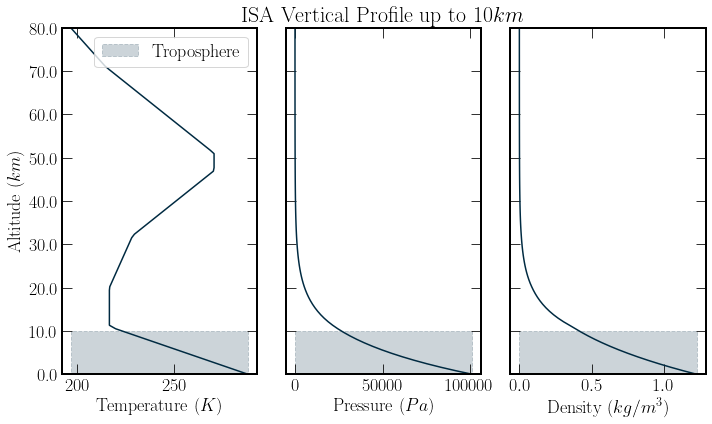

In [3]:
atlittudes = np.linspace(0,80000,100)
temp = isa.get_temperature(atlittudes)
pressure = isa.get_pressure(atlittudes)  
density = isa.get_density(atlittudes)
fig, ax = plt.subplots(1,3,figsize=(10, 6),sharey=True)
labels = ['Temperature $(K)$', 'Pressure $(Pa)$', 'Density $(kg/m^3)$']
for i, profile in enumerate([temp, pressure, density]):
    ax[i].plot(profile, atlittudes, color = colours.durham.ink)
    ax[i].fill_between([np.min(profile),np.max(profile)], [0,0], [10**4,10**4],
               linestyle='--',
               color=colours.durham.ink,
               label='Troposphere',
               alpha=0.2
    )
    ax[i].set_yticks(ax[i].get_yticks(),ax[i].get_yticks()/1000)
    ax[i].set_ylim(0,80000)
    ax[i].set_xlabel(labels[i])
ax[0].set_ylabel('Altitude $(km)$')
ax[1].set_title('ISA Vertical Profile up to $10km$')
ax[0].legend()

## Investigating The Magnitude of Pressure Broadening Up to 10km
The main changes in the atmoshphere as there is a h

In [35]:
main_ghg = ['H2O', 'CO2', 'N2O', 'CH4']
p_ground = isa.get_pressure(0)
p_trop = isa.get_pressure(10000)
t_trop = isa.get_temperature(10000)
print(t_trop)
abs_coef_ground = []
abs_coef_ptrop = []
abs_coef_ttrop = []
abs_coef_trop = []
for gas in main_ghg:
    abs_coef_ground.append(hapi.absorptionCoefficient_Voigt(SourceTables=gas))
    abs_coef_ptrop.append(hapi.absorptionCoefficient_Voigt(SourceTables=gas, Environment={'T':296,'p':p_trop/p_ground}))
    abs_coef_ttrop.append(hapi.absorptionCoefficient_Voigt(SourceTables=gas, Environment={'T':t_trop,'p':1}))
    abs_coef_trop.append(hapi.absorptionCoefficient_Voigt(SourceTables=gas, Environment={'T':t_trop,'p':p_trop/p_ground}))

223.14999999999998
{'air': 1.0}
11.653691 seconds elapsed for abscoef; nlines = 38350
{'air': 1.0}
12.348692 seconds elapsed for abscoef; nlines = 38350
{'air': 1.0}
10.823401 seconds elapsed for abscoef; nlines = 38350
{'air': 1.0}
12.149687 seconds elapsed for abscoef; nlines = 38350
{'air': 1.0}
27.182461 seconds elapsed for abscoef; nlines = 103240
{'air': 1.0}
31.787769 seconds elapsed for abscoef; nlines = 103240
{'air': 1.0}
27.247741 seconds elapsed for abscoef; nlines = 103240
{'air': 1.0}
30.685651 seconds elapsed for abscoef; nlines = 103240
{'air': 1.0}
6.799539 seconds elapsed for abscoef; nlines = 27201
{'air': 1.0}
8.918254 seconds elapsed for abscoef; nlines = 27201
{'air': 1.0}
7.264877 seconds elapsed for abscoef; nlines = 27201
{'air': 1.0}
8.272058 seconds elapsed for abscoef; nlines = 27201
{'air': 1.0}
37.835391 seconds elapsed for abscoef; nlines = 139468
{'air': 1.0}
41.324084 seconds elapsed for abscoef; nlines = 139468
{'air': 1.0}
36.282523 seconds elapsed fo

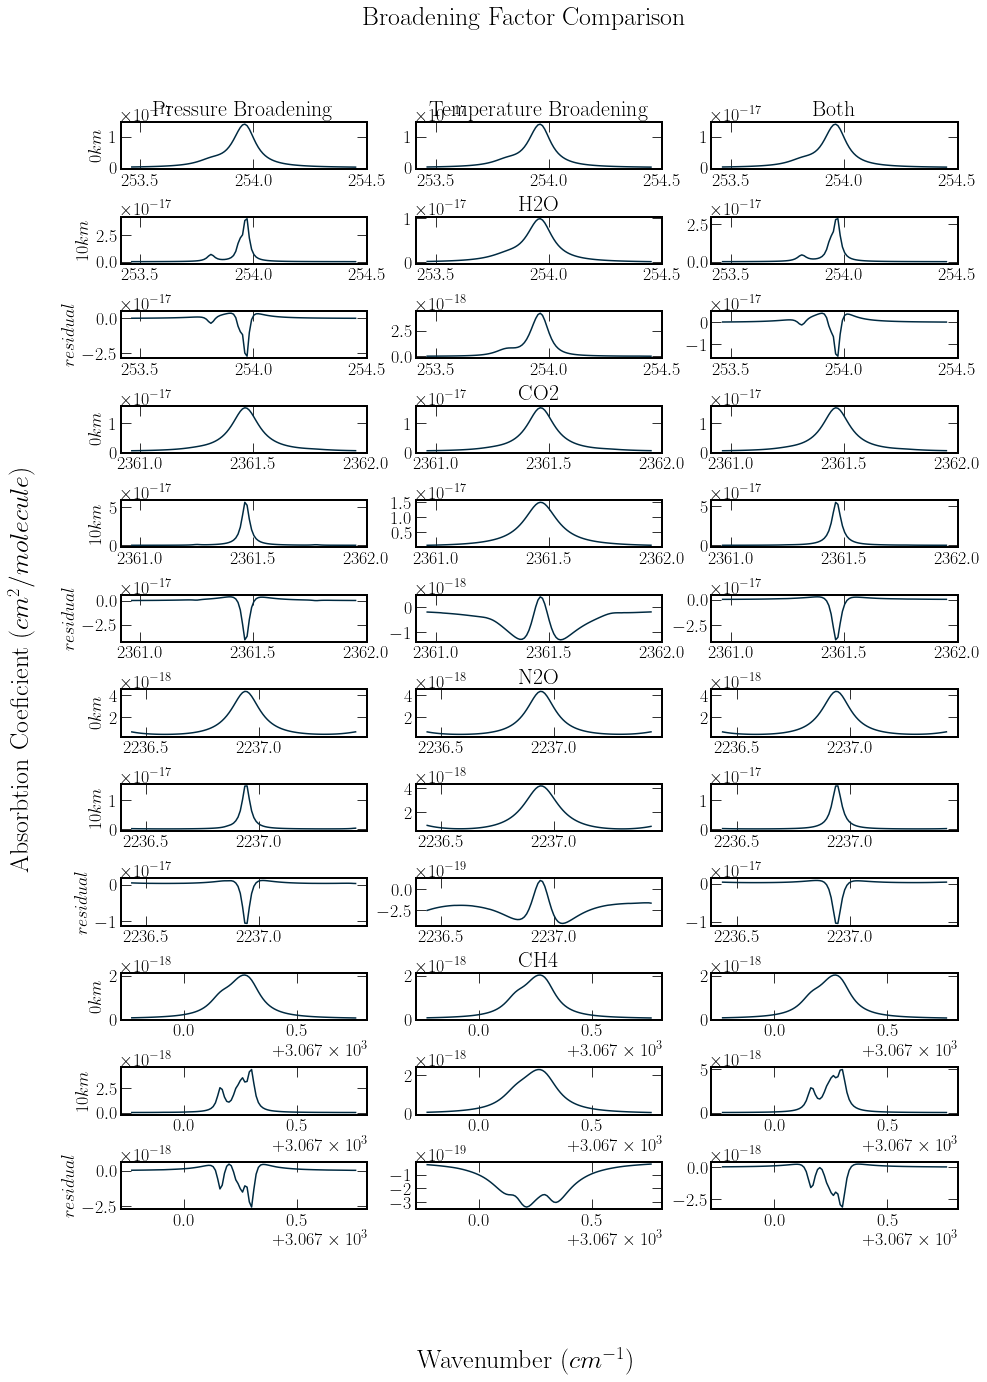

In [54]:
black = colours.durham.ink
integral_dict = {}
titles = ['Pressure Broadening', 'Temperature Broadening', 'Both']
height = ['0km', '10km', 'residual']
fig, ax = plt.subplots(len(main_ghg)*3,3, sharex=False, figsize=(15,20))
fig.set_tight_layout(False)
fig.suptitle('Broadening Factor Comparison',y =0.96)
fig.supxlabel('Wavenumber $(cm^{-1})$')
fig.supylabel('Absorbtion Coeficient $(cm^2/molecule)$') 
plt.subplots_adjust(hspace=1)
plt.ticklabel_format(axis='y',style='sci')
for j, abs in enumerate([abs_coef_ptrop, abs_coef_ttrop, abs_coef_trop]):
    for i, (ground, trop) in enumerate(zip(abs_coef_ground, abs)):
        nu_g, coef_g = ground
        nu_t, coef_t = trop
        max_pos = np.argmax(coef_g)
        half_size = 50
        max_slice = slice(max_pos-half_size,max_pos+half_size)
        residual = coef_g - coef_t
        integral_dict.update({
        ax[i*3,j].plot(nu_g[max_slice], coef_g[max_slice], c=black)
        ax[i*3+1,j].plot(nu_t[max_slice],coef_t[max_slice], c=black)
        ax[i*3+2,j].plot(nu_g[max_slice], residual[max_slice], c=black)
        ax[i*3,0].set_ylabel('$0km$')
        ax[i*3+1,0].set_ylabel('$10km$')
        ax[i*3+2,0].set_ylabel('$residual$')
    ax[0,j].set_title(titles[j])
    for i, gas in enumerate(main_ghg):
        if i !=0:
            ax[i*3,1].set_title(gas)
        else:
            ax[i*3+1,1].set_title(gas)